# Trabalho da disciplina de algoritmos não-supervisionados

O presente trabalho consiste na clusterização de uma base de dados de países em três grupos e a realização de determinadas análises dos resultados. A atividade foi desenvolvida utilizando a versão 3.9.15 do python e utilizando as bibliotecas constantes no arquivo country_clustering_requirements.txt.
A sequência de tópicos do trabalho é:

1. Importação das bibliotecas que serão usadas
2. Preparação dos dados
3. A utilização do método dos cotovelos apenas como um método auxiliar
4. A clusterização utilizando o algoritmo Kmeans
5. Clusterização hierárquica
6. Comparação entre os resultados das duas clusterizações
7. Identificação da contribuição das variáveis do problema nos resultados através da produção de gráficos
8. Verificação dos países de cada grupo para as duas clusterizações
9. Obtenção do país mais representativo de cada cluster por meio da menor distância euclidiana dos dados aos centroides

In [24]:
import numpy as np
import scipy
import scipy.spatial
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white", palette="pastel")
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

### 2. Preparação dos dados (Data-preparation)

Conforme observação realizada nas correções, nenhuma coluna do dataset foi alterada para a realização da clusterização. Ademais, alguns passos desnecessários foram removidos. Em resumo foram realizadas as seguintes ações:

- Leitura do arquivo .csv
- Verificação da presença de "outliers" por meio da análise dos percentils e da realização de "box plots"
- Remoção de eventuais valores nulos e NaN
- Obtenção da quantidade de países presentes no dataset. Foram encontrados 167 países

In [25]:
#Leitura da base de dados proveniente do Kaggle

country_data = pd.read_csv("../../datasets/Country-data.csv", index_col=0)
country_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [26]:
# Verificando a presença de outliers para 25%,50%,75%,90%,95% and 99% dos dados
country_data.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
90%,100.220000,70.800000,10.940000,75.420000,41220.000000,16.640000,80.400000,5.322000,41840.000000
95%,116.000000,80.570000,11.570000,81.140000,48290.000000,20.870000,81.400000,5.861000,48610.000000
99%,153.400000,160.480000,13.474000,146.080000,84374.000000,41.478000,82.370000,6.563600,79088.000000


### Boxplot

O boxplot realizado a seguir é, normalmente, utilizado para visualizar ou identificar se há presença de outliers nos dados, isto é, para visualizar se há dados muito afastados do centro de distribuição, afastados da média e da variância. Em outras palavras: para identificar dados discrepantes. Os dados que estiverem acima do último ponto superior são outliers.

/home/higoreller/miniconda3/envs/clustering-env/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


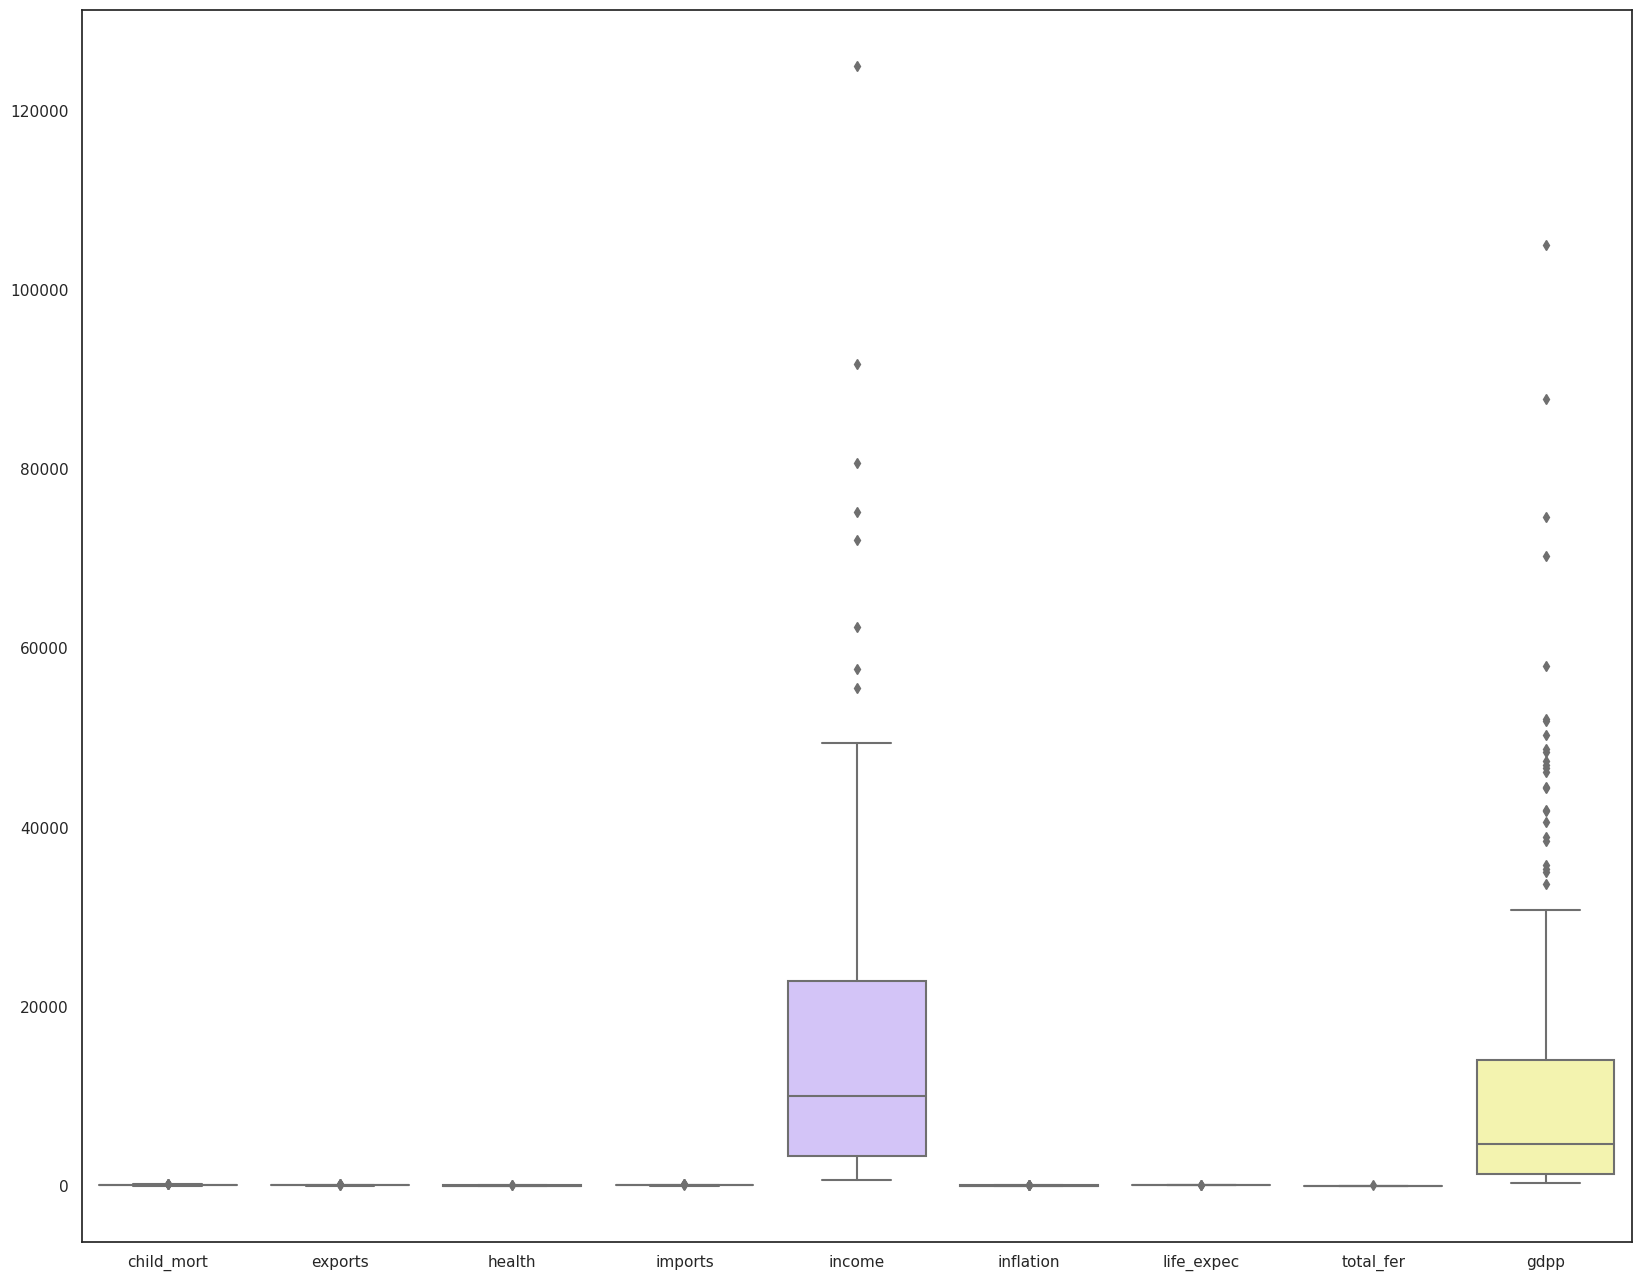

In [27]:
# Geração dos "box plots"
fig = plt.figure(figsize = (20,16))
sns.boxplot(data=country_data)
plt.show()

In [28]:
print("O número de países é: ", country_data.shape[0])

O número de países é:  167


In [29]:
country_data.isnull().sum()

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [30]:
country_data.isna().sum()

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

### 3. A utilização do método dos cotovelos apenas como um método auxiliar

Apesar do número de clusters já ser predefinido em três, é interessante verificar, apenas de forma auxiliar, se pelo método dos cotovelos este número de divisões faz sentido.

In [31]:
# Adotando o MinMaxScaler como normalizador apenas para realizar o método dos cotovelos
scaler = MinMaxScaler()
country_scaled = scaler.fit_transform(country_data)

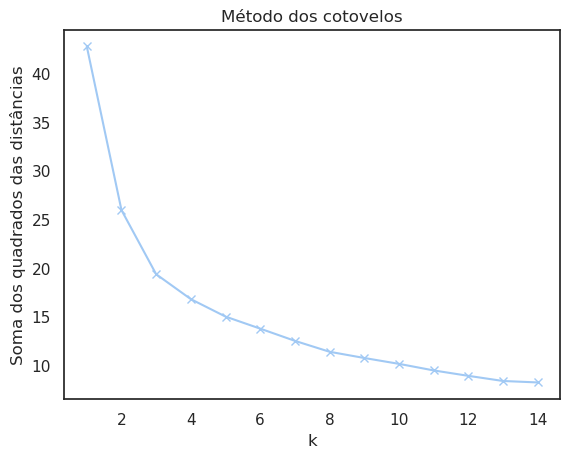

In [32]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(country_scaled)
    sum_of_squared_distances.append(km.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma dos quadrados das distâncias')
plt.title('Método dos cotovelos')
plt.show()

### 4. A clusterização utilizando o algoritmo Kmeans

Nesta etapa os seguintes passos foram adotados:
- Os dados foram normalizados de forma simples, para que estejam em uma mesma escada e as colunas não recebam graus de importância extremamente diferentes apenas devido as suas ordens de grandezas
- Após a normalização, a clusterização foi realizada utilizando o algoritmo Kmeans
- Uma nova coluna foi adicionada no dataset para representar os valores dos clusters para cada país

In [33]:
X = (country_data - country_data.mean(axis=0)) / country_data.std(axis=0)
X.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,1.287660,-1.134867,0.278251,-0.082208,-0.805822,0.156864,-1.614237,1.897176,-0.677143
Albania,-0.537333,-0.478220,-0.096725,0.070624,-0.374243,-0.311411,0.645924,-0.857394,-0.484167
Algeria,-0.272015,-0.098824,-0.963176,-0.639838,-0.220182,0.786908,0.668413,-0.038289,-0.463980
Angola,2.001787,0.773056,-1.443729,-0.164820,-0.583289,1.382894,-1.175698,2.121770,-0.514720
Antigua and Barbuda,-0.693548,0.160186,-0.286034,0.496076,0.101427,-0.599944,0.702147,-0.540321,-0.041692


In [34]:
kmeans_model = KMeans(n_clusters=3, random_state=42)
kmeans_model.fit(X)

country_data['kmeans_cluster'] = kmeans_model.labels_
country_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_cluster
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,2
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,2
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,2


### 5. Clusterização hierárquica


Text(0, 0.5, 'Distância Euclidiana')

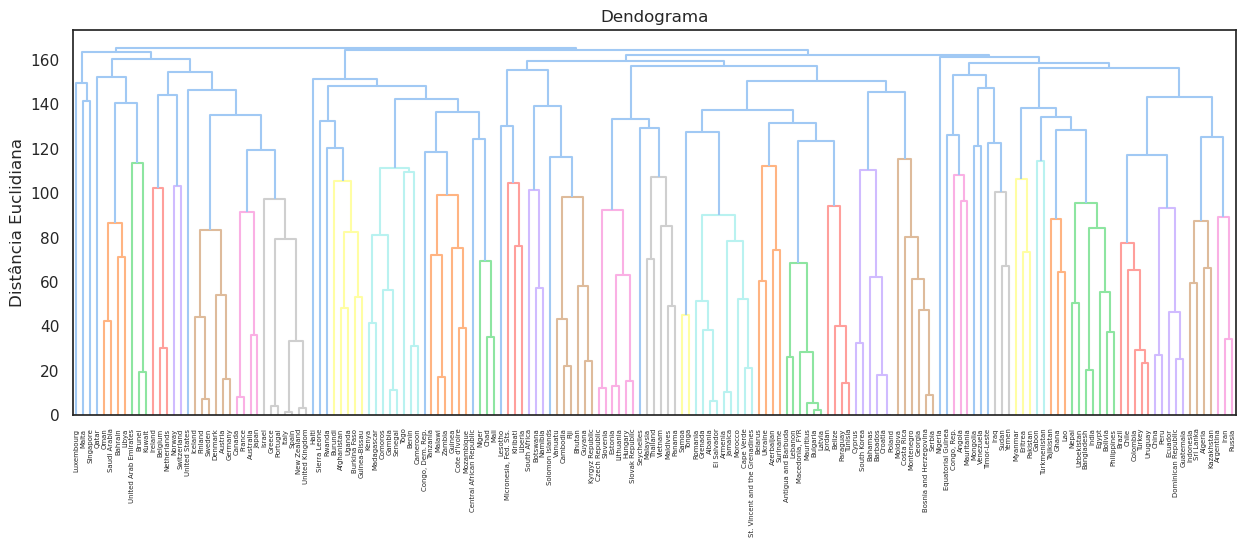

In [35]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

def plot_dendrogram(model, **kwargs):

    # Filho da clusterização hierárquica
    children = model.children_

    # Distâncias entre cada pair de filhos
    # Considerando que não temos essa informação, nós podemos usar uma distância uniforme para realizar a plotagem
    distance = np.arange(children.shape[0])

    # O número de observações contidas em cada nível de cluster
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Criação de uma "linkage matrix" e então é realizada a plotagem do dendograma
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plotagem do dendograma correspondente
    sch.dendrogram(linkage_matrix, **kwargs)

# Utilização do AgglomerativeClustering do sklearn
agg_model = AgglomerativeClustering(n_clusters=3, affinity = "euclidean",
                             linkage = 'ward')
agg_model_pred = agg_model.fit_predict(X)

plt.figure(figsize=(15, 5))
plt.grid(False)
plot_dendrogram(agg_model, labels=X.index)
plt.title('Dendograma')
plt.ylabel('Distância Euclidiana')

### 6. Comparação entre os resultados das duas clusterizações

Dos resultados percebe-se que as labels das clusterizações são diferentes. O cluster zero do K-médias corresponde ao cluster zero da HC. O cluster um do K-médias corresponde ao cluster dois da HC. O cluster dois do K-médias tem correspondência, ou deveria ter, com o cluster um da HC.

In [36]:
# Criação de uma coluna para comportar os dados da clusterização hierárquica
country_data['hier_cluster'] = agg_model.labels_
country_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_cluster,hier_cluster
country,,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1,2
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,2,1
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,2,1
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1,1
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,2,1


Text(0.5, 1.0, 'Cores segundo KMeans')

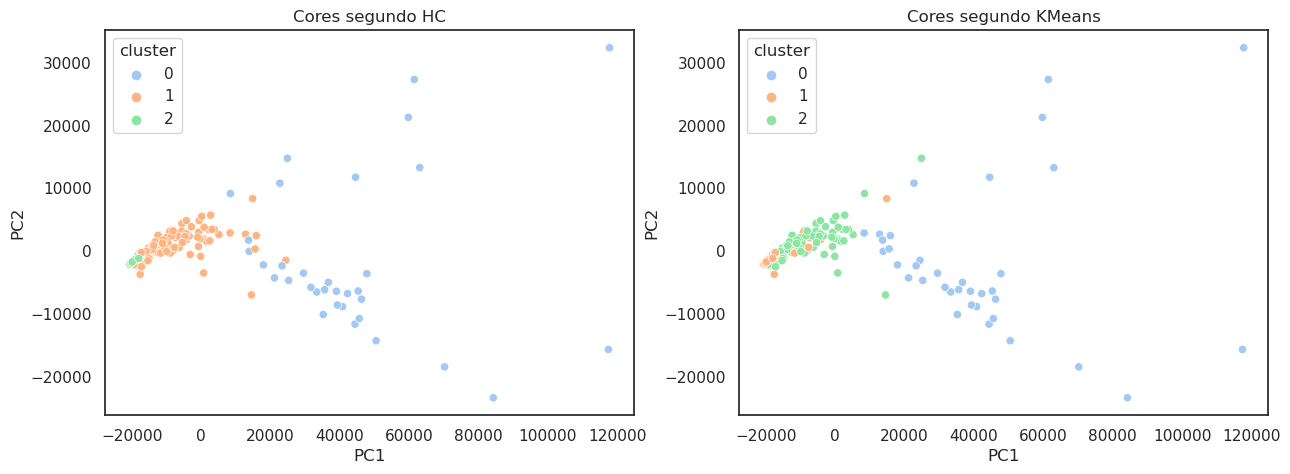

In [37]:
# Para que o plot seja em duas dimensões, o método PCA seleciona as dimensões mais relevantes com base na variância.
def plot_cluster_points(df, labels, ax=None):
    pca = PCA(2) 
    pca_data = pd.DataFrame(pca.fit_transform(df), columns=['PC1','PC2']) 
    pca_data['cluster'] = pd.Categorical(labels)
    sns.scatterplot(x="PC1", y="PC2", hue="cluster", data=pca_data, ax=ax)


fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plot_cluster_points(country_data, agg_model.labels_, ax=axs[0])
axs[0].set_title('Cores segundo HC')
plot_cluster_points(country_data, kmeans_model.labels_, ax=axs[1])

axs[1].set_title('Cores segundo KMeans')

In [38]:
kmeans_model.cluster_centers_

array([[-0.82496755,  0.64314557,  0.72523007,  0.19006732,  1.47979217,
        -0.48346661,  1.07634141, -0.78950242,  1.61114978],
       [ 1.35613914, -0.43622118, -0.15551629, -0.18863644, -0.68483442,
         0.40090504, -1.27833519,  1.36085106, -0.6024306 ],
       [-0.40523461, -0.03155768, -0.22379782,  0.02408916, -0.25101548,
        -0.01711594,  0.2539698 , -0.42307039, -0.3534185 ]])

### 7. Identificação da contribuição das variáveis do problema nos resultados através da produção de gráficos


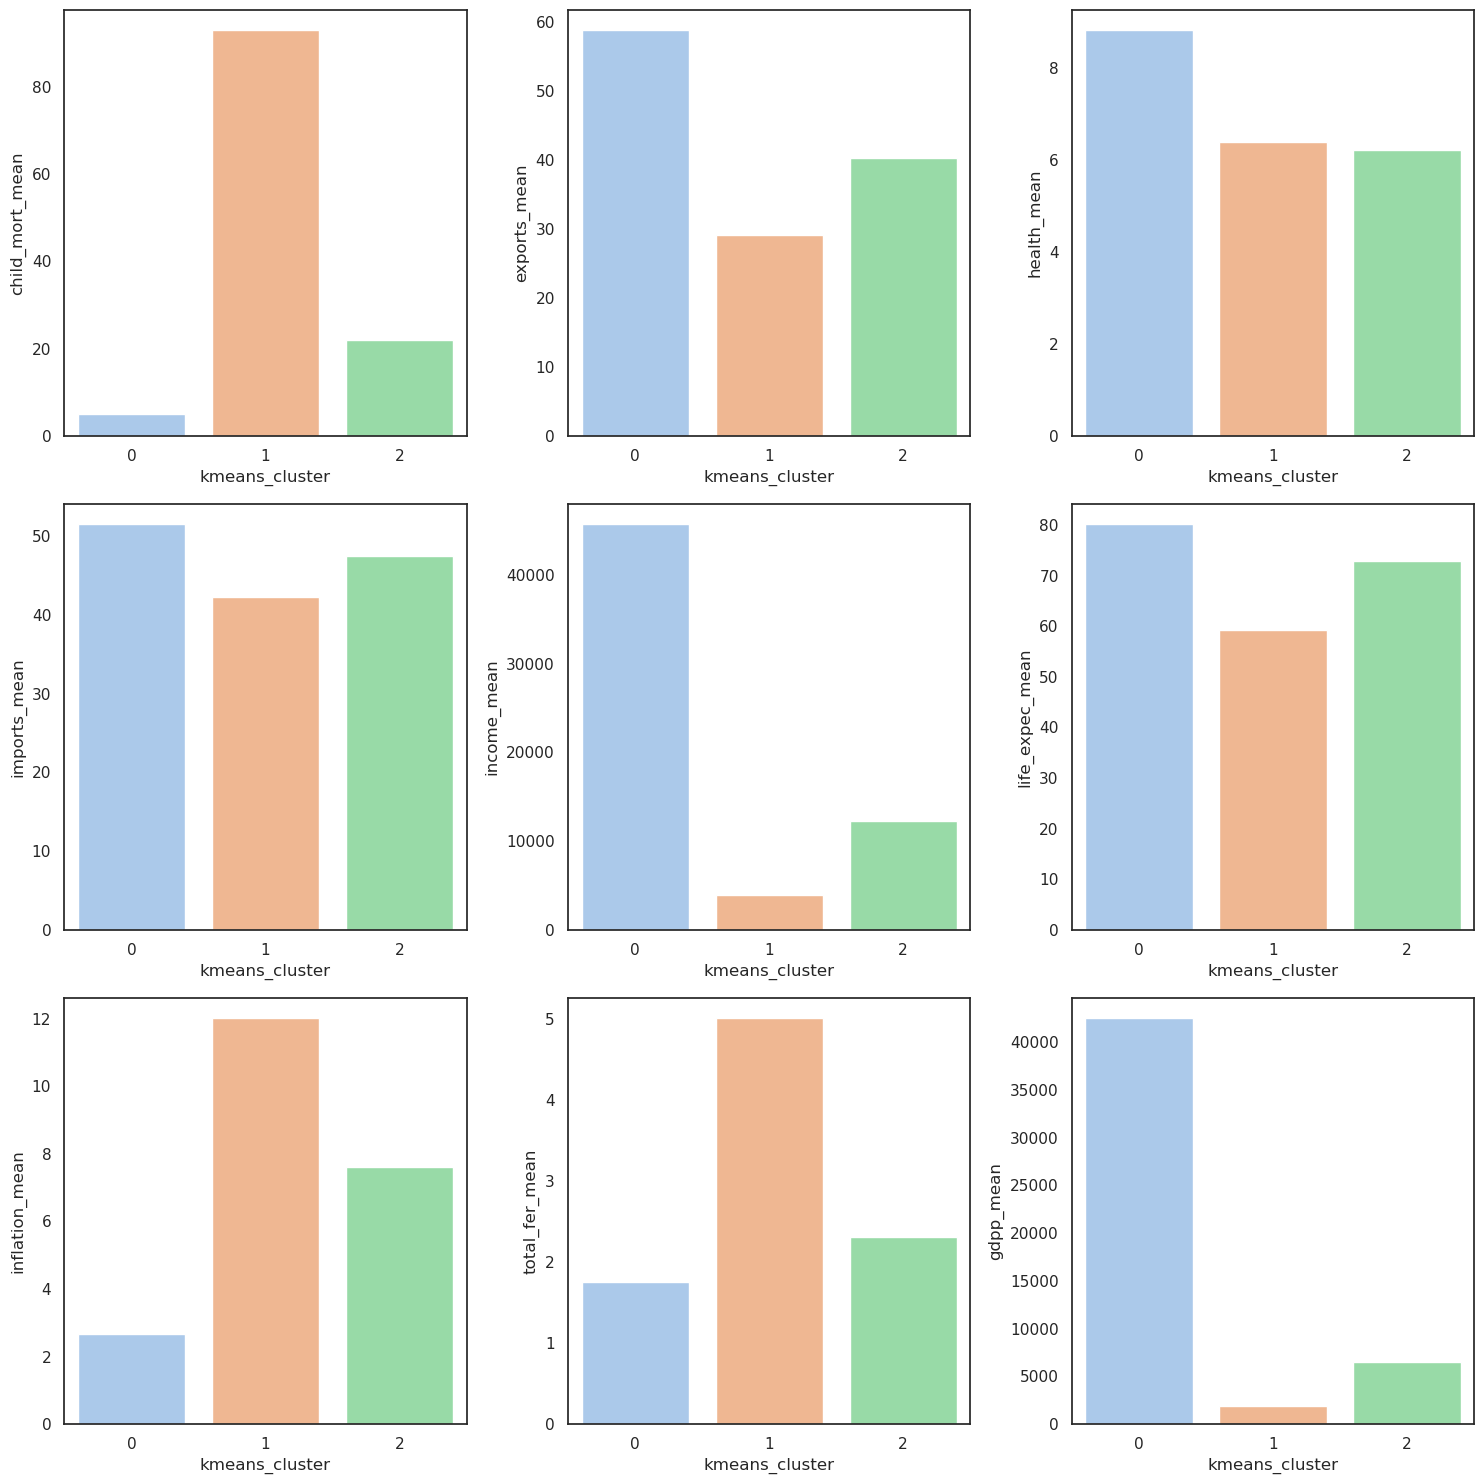

In [39]:
# Para o algoritmo de Kmeans foi obtida a média de cada coluna por grupo de cluster
# Essa ação ajuda a analisar o efeito de cada variável na clusterização

kmeans_clusters_child_mort = 	pd.DataFrame(country_data.groupby(["kmeans_cluster"]).child_mort.mean())
kmeans_clusters_exports = 	pd.DataFrame(country_data.groupby(["kmeans_cluster"]).exports.mean())
kmeans_clusters_health = 	pd.DataFrame(country_data.groupby(["kmeans_cluster"]).health.mean())
kmeans_clusters_imports = 	pd.DataFrame(country_data.groupby(["kmeans_cluster"]).imports.mean())
kmeans_clusters_income = 	pd.DataFrame(country_data.groupby(["kmeans_cluster"]).income.mean())
kmeans_clusters_inflation = 	pd.DataFrame(country_data.groupby(["kmeans_cluster"]).inflation.mean())
kmeans_clusters_life_expec = 	pd.DataFrame(country_data.groupby(["kmeans_cluster"]).life_expec.mean())
kmeans_clusters_total_fer = 	pd.DataFrame(country_data.groupby(["kmeans_cluster"]).total_fer.mean())
kmeans_clusters_gdpp = 	pd.DataFrame(country_data.groupby(["kmeans_cluster"]).gdpp.mean())

country_data_clustered = pd.concat([pd.Series(list(range(0,3))), kmeans_clusters_child_mort, kmeans_clusters_exports, kmeans_clusters_health, kmeans_clusters_imports,
               kmeans_clusters_income, kmeans_clusters_inflation, kmeans_clusters_life_expec, kmeans_clusters_total_fer, kmeans_clusters_gdpp], axis=1)
country_data_clustered.columns = ["kmeans_cluster", "child_mort_mean", "exports_mean", "health_mean", "imports_mean", "income_mean", "inflation_mean",
               "life_expec_mean", "total_fer_mean", "gdpp_mean"]
country_data_clustered

fig, axs = plt.subplots(3,3,figsize = (15,15))

sns.barplot(x=country_data_clustered.kmeans_cluster, y=country_data_clustered.child_mort_mean, ax = axs[0,0])
sns.barplot(x=country_data_clustered.kmeans_cluster, y=country_data_clustered.exports_mean, ax = axs[0,1])
sns.barplot(x=country_data_clustered.kmeans_cluster, y=country_data_clustered.health_mean, ax = axs[0,2])
sns.barplot(x=country_data_clustered.kmeans_cluster, y=country_data_clustered.imports_mean, ax = axs[1,0])
sns.barplot(x=country_data_clustered.kmeans_cluster, y=country_data_clustered.income_mean, ax = axs[1,1])
sns.barplot(x=country_data_clustered.kmeans_cluster, y=country_data_clustered.life_expec_mean, ax = axs[1,2])
sns.barplot(x=country_data_clustered.kmeans_cluster, y=country_data_clustered.inflation_mean, ax = axs[2,0])
sns.barplot(x=country_data_clustered.kmeans_cluster, y=country_data_clustered.total_fer_mean, ax = axs[2,1])
sns.barplot(x=country_data_clustered.kmeans_cluster, y=country_data_clustered.gdpp_mean, ax = axs[2,2])
plt.tight_layout()

In [40]:
# Pegando os resultados que foram agrupados em clusters diferentes do cluster zero no K-médias
country_data[country_data.kmeans_cluster == 0].loc[country_data.hier_cluster != 0]

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_cluster,hier_cluster
country,,,,,,,,,,,
Cyprus,3.6,50.2,5.97,57.5,33900,2.010,79.9,1.42,30800,0,1
Czech Republic,3.4,66.0,7.88,62.9,28300,-1.430,77.5,1.51,19800,0,1
Slovak Republic,7.0,76.3,8.79,77.8,25200,0.485,75.5,1.43,16600,0,1
Slovenia,3.2,64.3,9.41,62.9,28700,-0.987,79.5,1.57,23400,0,1
South Korea,4.1,49.4,6.93,46.2,30400,3.160,80.1,1.23,22100,0,1


In [41]:
# O correspondente do cluster um no K-médias é o cluster dois da HC, portanto, os valores dos clusters da HC diferentes de dois são divergentes
country_data[country_data.kmeans_cluster == 1].loc[country_data.hier_cluster != 2]

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_cluster,hier_cluster
country,,,,,,,,,,,
Angola,119.0,62.30,2.85,42.9,5900,22.40,60.1,6.16,3530,1,1
Botswana,52.5,43.60,8.30,51.3,13300,8.92,57.1,2.88,6350,1,1
"Congo, Rep.",63.9,85.10,2.46,54.7,5190,20.70,60.4,4.95,2740,1,1
Equatorial Guinea,111.0,85.80,4.48,58.9,33700,24.90,60.9,5.21,17100,1,1
Eritrea,55.2,4.79,2.66,23.3,1420,11.60,61.7,4.61,482,1,1
Gabon,63.7,57.70,3.50,18.9,15400,16.60,62.9,4.08,8750,1,1
Ghana,74.7,29.50,5.22,45.9,3060,16.60,62.2,4.27,1310,1,1
Iraq,36.9,39.40,8.41,34.1,12700,16.60,67.2,4.56,4500,1,1
Kiribati,62.7,13.30,11.30,79.9,1730,1.52,60.7,3.84,1490,1,1


In [42]:
# O correspondente do cluster dois no K-médias é o cluster um da HC, portanto, os valores dos clusters da HC diferentes de um são divergentes
country_data[country_data.kmeans_cluster == 2].loc[country_data.hier_cluster != 1]

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_cluster,hier_cluster
country,,,,,,,,,,,
Libya,16.6,65.6,3.88,42.1,29600,14.2,76.1,2.41,12100,2,0
Oman,11.7,65.7,2.77,41.2,45300,15.6,76.1,2.90,19300,2,0
Saudi Arabia,15.7,49.6,4.29,33.0,45400,17.2,75.1,2.96,19300,2,0


### 8. Verificação dos países de cada grupo para as duas clusterizações


In [43]:
print(country_data[country_data.kmeans_cluster == 2].index)
print(country_data[country_data.hier_cluster == 1].index)

Index(['Albania', 'Algeria', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Azerbaijan', 'Bahamas', 'Bangladesh', 'Barbados', 'Belarus', 'Belize',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria',
       'Cambodia', 'Cape Verde', 'Chile', 'China', 'Colombia', 'Costa Rica',
       'Croatia', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Estonia', 'Fiji', 'Georgia', 'Grenada', 'Guatemala', 'Guyana',
       'Hungary', 'India', 'Indonesia', 'Iran', 'Jamaica', 'Jordan',
       'Kazakhstan', 'Kyrgyz Republic', 'Latvia', 'Lebanon', 'Libya',
       'Lithuania', 'Macedonia, FYR', 'Malaysia', 'Maldives', 'Mauritius',
       'Micronesia, Fed. Sts.', 'Moldova', 'Mongolia', 'Montenegro', 'Morocco',
       'Myanmar', 'Nepal', 'Oman', 'Panama', 'Paraguay', 'Peru', 'Philippines',
       'Poland', 'Romania', 'Russia', 'Samoa', 'Saudi Arabia', 'Serbia',
       'Seychelles', 'Solomon Islands', 'Sri Lanka',
       'St. Vincent and the Grenadines', 'Suri

In [44]:
print(country_data[country_data.kmeans_cluster == 1].index)
print(country_data[country_data.hier_cluster == 2].index)

Index(['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
       'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Cote d'Ivoire', 'Equatorial Guinea',
       'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
       'Haiti', 'Iraq', 'Kenya', 'Kiribati', 'Lao', 'Lesotho', 'Liberia',
       'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Namibia',
       'Niger', 'Nigeria', 'Pakistan', 'Rwanda', 'Senegal', 'Sierra Leone',
       'South Africa', 'Sudan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda',
       'Yemen', 'Zambia'],
      dtype='object', name='country')
Index(['Afghanistan', 'Benin', 'Burkina Faso', 'Burundi', 'Cameroon',
       'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.',
       'Cote d'Ivoire', 'Gambia', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Kenya',
       'Madagascar', 'Malawi', 'Mali', 'Mozambique', 'Niger', 'Rwanda',
       'Senegal', 'Sierra Leone', 'T

In [45]:
print(country_data[country_data.kmeans_cluster == 0].index)
print(country_data[country_data.hier_cluster == 0].index)

Index(['Australia', 'Austria', 'Bahrain', 'Belgium', 'Brunei', 'Canada',
       'Cyprus', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany',
       'Greece', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kuwait',
       'Luxembourg', 'Malta', 'Netherlands', 'New Zealand', 'Norway',
       'Portugal', 'Qatar', 'Singapore', 'Slovak Republic', 'Slovenia',
       'South Korea', 'Spain', 'Sweden', 'Switzerland', 'United Arab Emirates',
       'United Kingdom', 'United States'],
      dtype='object', name='country')
Index(['Australia', 'Austria', 'Bahrain', 'Belgium', 'Brunei', 'Canada',
       'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Iceland',
       'Ireland', 'Israel', 'Italy', 'Japan', 'Kuwait', 'Libya', 'Luxembourg',
       'Malta', 'Netherlands', 'New Zealand', 'Norway', 'Oman', 'Portugal',
       'Qatar', 'Saudi Arabia', 'Singapore', 'Spain', 'Sweden', 'Switzerland',
       'United Arab Emirates', 'United Kingdom', 'United States'],
      dtype='object', na

### 9. Obtenção do país mais representativo de cada cluster por meio da menor distância euclidiana dos dados aos centroides


In [46]:
# Obtenção dos países mais representativos de cada cluster por meio da obtenção da distância euclidiana mínima
for i in range(3):
  most_representative_country_cluster_0 = [np.min(np.linalg.norm(data-kmeans_model.cluster_centers_[i], 2)) for data in np.array(X)]
  minimum_distance_cluster_0 = np.array(most_representative_country_cluster_0).min()
  print(minimum_distance_cluster_0)
  index_cluster_0 = most_representative_country_cluster_0.index(minimum_distance_cluster_0)
  print(X.index[index_cluster_0])


0.7295699993767515
Iceland
0.8266017827681945
Guinea
0.7321774274889798
Jamaica
